In [1]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Layer

In [2]:
# Loading dataset
def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
    return (x_train, y_train), (x_test, y_test)

In [3]:
# Creating triplets
def create_triplets(x, y, num_triplets=10000):
    triplets = []
    labels = []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for _ in range(num_triplets):
        anchor_label = random.randint(0, num_classes - 1)
        anchor_idx = random.choice(digit_indices[anchor_label])
        positive_idx = random.choice(digit_indices[anchor_label])

        negative_label = random.randint(0, num_classes - 1)
        while negative_label == anchor_label:
            negative_label = random.randint(0, num_classes - 1)
        negative_idx = random.choice(digit_indices[negative_label])

        triplets.append((x[anchor_idx], x[positive_idx], x[negative_idx]))
        labels.append(anchor_label)

    triplets = np.array(triplets)
    return triplets

In [4]:
# Building the siamese network
def build_siamese_network(input_shape):
    base_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(base_input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return models.Model(base_input, x)

In [5]:
# Calculating Triplet Loss
def triplet_loss(y_true, y_pred, margin=0.2):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    return tf.reduce_mean(tf.maximum(positive_distance - negative_distance + margin, 0))

In [6]:
#Creating a triplet model
class TripletStack(Layer):
    def call(self, inputs):
        anchor, positive, negative = inputs
        return tf.stack([anchor, positive, negative], axis=1)



def create_triplet_model(input_shape):
    base_model = build_siamese_network(input_shape)

    input_anchor = layers.Input(shape=input_shape)
    input_positive = layers.Input(shape=input_shape)
    input_negative = layers.Input(shape=input_shape)

    embedding_anchor = base_model(input_anchor)
    embedding_positive = base_model(input_positive)
    embedding_negative = base_model(input_negative)

    stacked_embeddings = TripletStack()([embedding_anchor, embedding_positive, embedding_negative])
    model = models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=stacked_embeddings)
    return model

In [7]:
#Training the model
def train_model(model, triplets_train, triplets_test, epochs=15, batch_size=64):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=triplet_loss)
    history = model.fit(
        [triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]],
        np.zeros(len(triplets_train)),
        validation_data=([triplets_test[:, 0], triplets_test[:, 1], triplets_test[:, 2]],
                         np.zeros(len(triplets_test))),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

In [8]:
#T-SNE plot
def visualize_embeddings(base_model, x, y):
    embeddings = base_model.predict(x)
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y, cmap='viridis', s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.5962 - val_loss: 0.0350
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0429 - val_loss: 0.0296
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0373 - val_loss: 0.0292
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.0323 - val_loss: 0.0292
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0322 - val_loss: 0.0274
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0282 - val_loss: 0.0262
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0247 - val_loss: 0.0273
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0254 - val_loss: 0.0265
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0243 - val_loss: 0.0331
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.0224 - val_loss: 0.0287
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0208 - val_loss: 0.0261
Epoch 12/15
313/313 ━━━━━━━━━

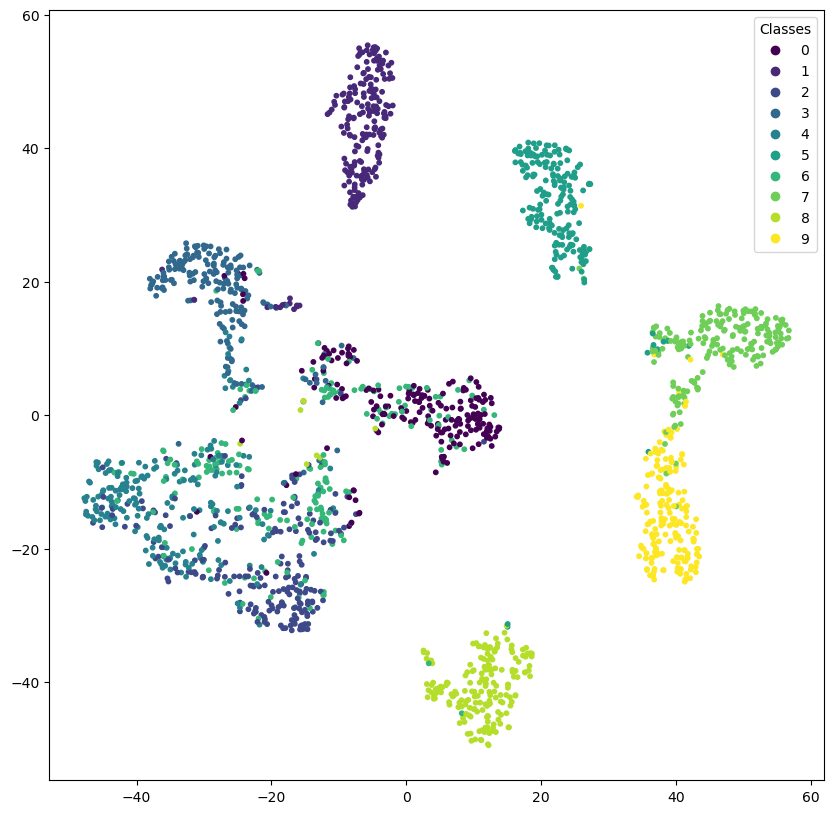

In [9]:
# Training the triplet model
if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = load_data()
    triplets_train = create_triplets(x_train, y_train, num_triplets=20000)
    triplets_test = create_triplets(x_test, y_test, num_triplets=5000)

    input_shape = x_train.shape[1:]
    triplet_model = create_triplet_model(input_shape)
    train_model(triplet_model, triplets_train, triplets_test)


    base_model = triplet_model.layers[3]
    visualize_embeddings(base_model, x_test[:2000], y_test[:2000])

In [10]:
# Function to calculate euclidean distance of embeddings
def calculate_distance(embedding_a, embedding_b):
    return np.linalg.norm(embedding_a - embedding_b, axis=-1)

# Function to retrieve the most similar images (Lowest embedding distance)
def generate_top_matches(base_model, x_test, y_test, query_index, top_k=5):

    embeddings = base_model.predict(x_test)
    query_embedding = embeddings[query_index]

    distances = np.array([calculate_distance(query_embedding, e) for e in embeddings])

    sorted_indices = np.argsort(distances)
    top_matches = sorted_indices[:top_k + 1]

    return top_matches[1:], distances[top_matches[1:]]

In [11]:
# Evaluation metrics
def evaluate_similarity(base_model, x_test, y_test, top_k=5, num_queries=100):
    precision_list, recall_list, accuracy_list = [], [], []

    for query_index in np.random.choice(len(x_test), num_queries, replace=False):
        query_label = y_test[query_index]

        top_matches, _ = generate_top_matches(base_model, x_test, y_test, query_index, top_k)
        top_labels = y_test[top_matches]

        relevant_matches = np.sum(top_labels == query_label)
        precision = relevant_matches / top_k
        recall = relevant_matches / np.sum(y_test == query_label)
        accuracy = int(query_label in top_labels)

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)

    return (
        np.mean(precision_list),
        np.mean(recall_list),
        np.mean(accuracy_list)
    )

if __name__ == "__main__":
    top_k = 5
    precision, recall, accuracy = evaluate_similarity(base_model, x_test[:2000], y_test[:2000], top_k=top_k)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━

In [12]:
# Function to plot top-k similar images
def plot_similar_images(query_image, database_images, query_embedding, database_embeddings, top_k=5, cmap='viridis'):
    # Compute distances between the query embedding and database embeddings
    distances = np.linalg.norm(database_embeddings - query_embedding, axis=1)

    # Get indices of the top-k smallest distances (most similar images)
    top_k_indices = np.argsort(distances)[:top_k]

    # Plot the query image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_image.squeeze(), cmap=cmap)
    plt.title("Query Image")
    plt.axis('off')

    # Plot the top-k similar images
    for i, idx in enumerate(top_k_indices):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(database_images[idx].squeeze(), cmap=cmap)
        plt.title(f"Rank {i + 1}")
        plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


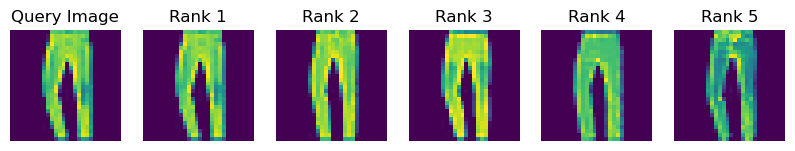

In [13]:
# Generating similar images
input_shape = (28, 28, 1)
siamese_model = build_siamese_network(input_shape)
triplet_model = create_triplet_model(input_shape)

triplet_model.compile(optimizer='adam', loss=triplet_loss)

# Generate embeddings for the query and database
query_image = x_test[5]  # Query image
database_images = x_test

# Extract embeddings using the base model (feature extractor)
query_embedding = siamese_model.predict(query_image[np.newaxis, ...])  # Single image embedding
database_embeddings = siamese_model.predict(database_images)  # Database embeddings

# Plot the top-5 similar images
plot_similar_images(query_image, database_images, query_embedding, database_embeddings, top_k=5, cmap='viridis')

In [18]:
# Save the trained Siamese model
siamese_model.save('siamese_model.h5')
print("Model saved successfully!'")

Model saved successfully!'


In [19]:
siamese_model.save('siamese_model.keras')
print("Model saved successfully in keras format'")

Model saved successfully in keras format'
